# Работа с текстовыми данными (часть 2)

Задание: Обучите модель для определения принадлежности текста к одному из заданных классов. При разборе текста используйте разбор текста по частям речи

Для решения этого задания мы будем использовать библиотеку SpaCy (https://spacy.io/).
Библиотека spaCy выделяется своей эффективностью и производительностью. Она разработана с акцентом на скорость и точность, что делает ее предпочтительным выбором для многих разработчиков и исследователей в области NLP.

Основные концепции spaCy:

1. Токенизация и сегментация текста

2. Разделение текста на слова и пунктуацию.

Для начала установим эту библиотеку и скачаем необходимые модели:

In [ ]:
# Если вы работаете через conda-окружение, есть смысл установить эти пакеты через консоль
%pip install -U spacy
%pip install -U spacy-lookups-data
#!python -m spacy download en_core_web_sm #для анализа английских текстов
!python -m spacy download ru_core_news_lg #для анализа русских текстов. Модель достаточно объёмная (513.4 Мб)

In [203]:
#проверка, что модели адекватно скачались
!python -m spacy validate


⠙ Loading compatibility table...
⠹ Loading compatibility table...
⠸ Loading compatibility table...
⠼ Loading compatibility table...
⠴ Loading compatibility table...
✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.7.2) =================
ℹ spaCy installation:
c:\PROGRA~3\ANACON~1\envs\spacy_condaenv\Lib\site-packages\spacy

NAME              SPACY            VERSION                            
en_core_web_sm    >=3.7.2,<3.8.0   3.7.1   ✔
ru_core_news_lg   >=3.7.0,<3.8.0   3.7.0   ✔



In [204]:
# импортируем необходимые модули для нашей работы

import spacy
from spacy import displacy

import os
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Для начала просто "поиграем" с библиотекой и посмотрим на её возможности:

##### Токенизация текста

In [4]:
# Загружаем языковую модель
nlp = spacy.load("en_core_web_sm")

# Входной текст
text = "spaCy is an amazing tool for natural language processing."

# Применяем токенизацию
doc = nlp(text)

# Выводим токены (слова и пунктуацию) из текста
for token in doc:
    print(token.text)

spaCy
is
an
amazing
tool
for
natural
language
processing
.


##### Разбиение текста на предложения

In [5]:
# Входной текст с несколькими предложениями
text = "SpaCy is fast. It's also efficient."

# Применяем разбиение на предложения
doc = nlp(text)

# Выводим предложения из текста
for sentence in doc.sents:
    print(sentence.text)

SpaCy is fast.
It's also efficient.


##### Частеречная разметка (POS-тегирование)

**Определение частей речи слов**

Частеречная разметка (Part-of-Speech tagging или POS-тегирование) – это процесс присвоения каждому слову в тексте определенной метки, соответствующей его грамматической роли. SpaCy предоставляет мощные инструменты для выполнения этой задачи.

**Значение частей речи для анализа текста**

Части речи являются ключевыми элементами анализа текста, поскольку они раскрывают структуру и смысл предложения. Различные части речи могут указывать на субъект, объект, действие, качество и т.д. Эта информация имеет большое значение для множества приложений, от анализа тональности до извлечения информации.

In [6]:
# Входной текст
text = "I like to read books."

# Применяем анализ
doc = nlp(text)

# Выводим слова и их части речи
for token in doc:
    print(token.text, token.pos_)

I PRON
like VERB
to PART
read VERB
books NOUN
. PUNCT


##### Лемматизация и нормализация

Приведение слов к их базовой форме

**Лемматизация** - это процесс приведения слова к его базовой форме (лемме) путем удаления окончаний и суффиксов. Это помогает унифицировать различные формы слова и улучшить точность анализа.

**Важность лемматизации при анализе текста**

Лемматизация позволяет снизить размерность данных, учитывая только базовые формы слов. Это особенно полезно, например, при анализе тональности, чтобы учесть все формы одного слова, когда выражается какой-либо оттенок.

In [7]:
text = "running dogs are happily barking"

doc = nlp(text)

for token in doc:
    print(token.text, token.lemma_)

running run
dogs dog
are be
happily happily
barking bark


In [8]:
# интересно посмотреть также пример на русском языке:
nlp_rus = spacy.load('ru_core_news_lg')
lemm = nlp_rus('А розы упали на лапу Азора')
for token in lemm:
    print(token.text, token.lemma_)

##### Именованная сущность (NER)

Обнаружение и классификация именованных сущностей

**Именованные сущности (Named Entities)** - это объекты реального мира, которые можно идентифицировать по имени, такие как имена людей, места, даты, организации и т.д. Извлечение и классификация именованных сущностей является важной задачей в NLP. SpaCy предоставляет удобные инструменты для этой цели.

**Применение NER в задачах информационного поиска**

Извлечение именованных сущностей имеет множество применений. В информационном поиске, например, оно может быть использовано для автоматической классификации документов по тематикам, выделения ключевых фактов или для создания связей между сущностями.

In [10]:
text = "Apple is going to build a new office in London in 2023."

doc = nlp(text)

for ent in doc.ents:
    print(ent.text, ent.label_)

Apple ORG
London GPE
2023 DATE


##### Работа с векторными представлениями

**Векторные представления слов** - это числовые векторы, представляющие слова в многомерном пространстве таким образом, что семантически близкие слова имеют близкие векторы. Это понятие основано на гипотезе о дистрибутивности, согласно которой слова, используемые в похожих контекстах, имеют схожие значения.

**Использование встроенных векторов слов в spaCy**

Одной из мощных особенностей spaCy является наличие встроенных векторов слов, которые могут быть использованы для анализа семантической близости и сходства между словами. Эти векторы обучены на больших объемах текста и позволяют сравнивать слова на основе их семантического значения.

Для примера, используем векторное представление для сравнения двух слов:

In [11]:
# Получаем векторное представление слова "cat"
vector_cat = nlp("cat").vector

# Получаем векторное представление слова "dog"
vector_dog = nlp("dog").vector

# Вычисляем косинусное расстояние между векторами
similarity = np.dot(vector_cat, vector_dog) / np.linalg.norm(vector_cat) * np.linalg.norm(vector_dog)

print("Similarity between 'cat' and 'dog':", similarity)

Similarity between 'cat' and 'dog': 44.597546


Также в spacy представлена возможность визуализировать состав предложения:

In [ ]:
text = "Quick brawn fox jumps over the lazy dog"
doc = nlp(text)

displacy.render(doc, style='dep', jupyter=True,options={'distance': 140})

In [ ]:
spacy.explain("ADJ"),spacy.explain("det") ,spacy.explain("ADP") ,spacy.explain("prep") ,spacy.explain("amod"),spacy.explain("case"),spacy.explain("nmod"),spacy.explain("conj") 

('adjective',
 'determiner',
 'adposition',
 'prepositional modifier',
 'adjectival modifier',
 'case marking',
 'modifier of nominal',
 'conjunct')

Перейдём к нашему основному заданию.

Проанализируем стихотворения С.А.Есенина и других случайных авторов и попробуем решить задачу бинарной классификации.

In [275]:
os.chdir(r"C:/Users/Анна/Desktop/ML занятия/HSE ML/HSE ML/DataSets/Text/Text/Text")

data_es = pd.read_csv('esenin-2.csv')
data_rand = pd.read_csv('random-2.csv')

In [276]:
# посмотрим на данные
data_es

,id,poem
0,0,"Есть музыка, стихи и танцы,\r\r\nЕсть ложь и л..."
1,1,"Радость, как плотвица быстрая,\r\r\nЮрко свети..."
2,2,Алый мрак в небесной черни\r\r\nНачертил пожар...
3,3,"Сестре Шуре\r\r\n\r\r\nАх, как мн..."
4,4,"Ах, метель такая, просто черт возьми!\r\r\nЗаб..."
...,...,...
338,338,"Я снова здесь, в семье родной,\r\r\nМой край, ..."
339,339,"Я спросил сегодня у менялы,\r\r\nЧто даёт за п..."
340,340,Я странник убогий.\r\r\nС вечерней звездой\r\r...
341,341,Я усталым таким еще не был\r\r\nВ эту серую мо...


Классифицируем стихи С.А.Есенина в класс "1", а остальные - в класс "0" и создадим единый датафрейм.

In [277]:
data_es['Class'] = 1
data_rand['Class'] = 0
data = pd.concat([data_es, data_rand], axis=0)
data = data.sample(frac=1).reset_index(drop=True) #перемешиваем данные

In [278]:
# посмотрим распределение датасета по классам
data['Class'].value_counts()

Class
0    500
1    343
Name: count, dtype: int64

Сначала мы используем возможности Spacy для извлечения векторов из текста и построения модели классификации.

Векторы в spaCy строятся с использованием предварительно обученных моделей, которые обучаются на больших корпусах текста. Эти модели используют алгоритмы глубокого обучения для извлечения семантической информации из текста и представления ее в виде числовых векторов.

Процесс построения векторов в spaCy включает следующие шаги:

1. Загрузка предварительно обученной модели spaCy для выбранного языка. Например, вы можете загрузить модель "en_core_web_sm" для английского языка с помощью команды nlp = spacy.load("ru_core_news_lg").

2. Обработка текста с помощью объекта nlp. Это преобразует текст в объект, который содержит различные атрибуты и методы для работы с текстом.

3. Для каждого токена в тексте можно получить его векторное представление с помощью атрибута token.vector. Вектор представляет собой числовое представление, которое кодирует семантическую информацию о токене.

In [279]:
nlp_rus = spacy.load("ru_core_news_lg")
data['vector'] = data['poem'].apply(lambda text:nlp_rus(text).vector)

In [280]:
data.head()

,id,poem,Class,vector
0,85,"Закружилась пряжа снежистого льна,\r\r\nПанихи...",1,"[0.008179255, -0.0838492, -0.0036151786, -0.01..."
1,60,Да! Теперь - решено. Без возврата\r\r\nЯ покин...,1,"[0.010795925, -0.103469126, -0.055959124, 0.02..."
2,231,"Сонет\r\r\n\r\r\nЯ полюбил тебя, лиш...",0,"[0.009962686, -0.14169772, -0.06941799, 0.0451..."
3,172,Неуютная жидкая лунность\r\r\nИ тоска бесконеч...,1,"[-0.01259486, -0.0992094, -0.06247462, -0.0033..."
4,124,"Хочешь видеть жребий свой\r\r\n В зеркале, С...",0,"[-0.0029084196, -0.10747848, -0.05332973, 0.02..."


Далее переходим к уже привычному нам способу построения моделей:

In [281]:
X = pd.DataFrame(data['vector'].to_list())
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [282]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
res_knn = knn_model.predict(X_test)

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
res_nb = nb_model.predict(X_test)

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
res_dt = dt_model.predict(X_test)

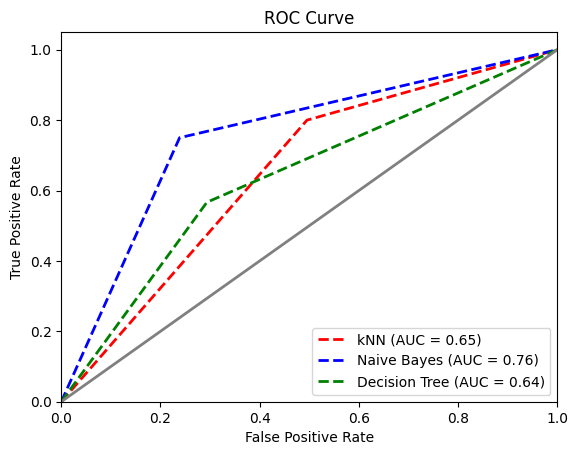

In [284]:
# Вычисление ROC-кривых
fpr_knn, tpr_knn, _ = roc_curve(y_test, res_knn)
fpr_nb, tpr_nb, _ = roc_curve(y_test, res_nb)
fpr_dt, tpr_dt, _ = roc_curve(y_test, res_dt)

# Рассчитать площадь под ROC-кривой (AUC-ROC)
auc_knn = roc_auc_score(y_test, res_knn)
auc_nb = roc_auc_score(y_test, res_nb)
auc_dt = roc_auc_score(y_test, res_dt)

# Визуализировать ROC-кривую
plt.plot(fpr_knn, tpr_knn, color='red', lw=2, linestyle='--', label=f'kNN (AUC = {auc_knn:.2f})')
plt.plot(fpr_nb, tpr_nb, color='blue', lw=2, linestyle='--', label=f'Naive Bayes (AUC = {auc_nb:.2f})')
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, linestyle='--', label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

<Axes: title={'center': 'Conf matrix DT'}>

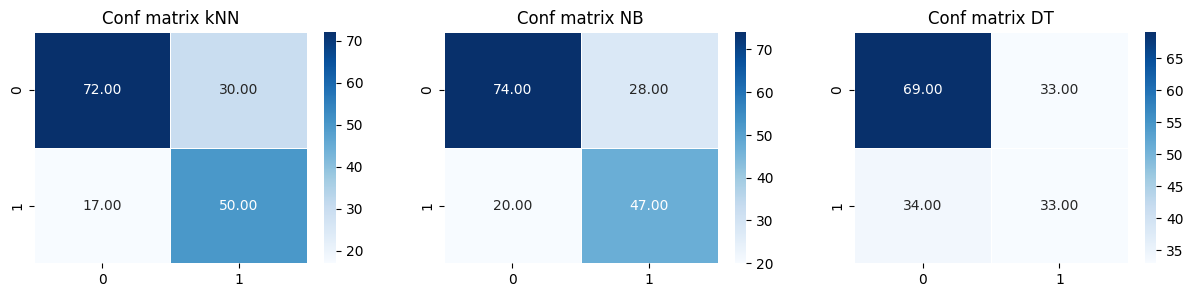

In [225]:
plt.figure(figsize=(15,3))

conf_matrix_knn = confusion_matrix(y_test, res_knn)
conf_matrix_nb = confusion_matrix(y_test, res_nb)
conf_matrix_dt = confusion_matrix(y_test, res_dt)

plt.subplot(1, 3, 1)
plt.title('Conf matrix kNN')
sns.heatmap(conf_matrix_knn,cmap='Blues',annot=True, fmt=".2f", linewidths=0.5)

plt.subplot(1, 3, 2)
plt.title('Conf matrix NB')
sns.heatmap(conf_matrix_nb,cmap='Blues',annot=True, fmt=".2f", linewidths=0.5)

plt.subplot(1, 3, 3)
plt.title('Conf matrix DT')
sns.heatmap(conf_matrix_dt,cmap='Blues',annot=True, fmt=".2f", linewidths=0.5)

In [219]:
print('Результат kNN: \n', classification_report(y_test, res_knn))
print('Результат NB: \n', classification_report(y_test, res_nb))
print('Результат Decision Tree: \n', classification_report(y_test, res_dt))

Результат kNN: 
               precision    recall  f1-score   support

           0       0.81      0.71      0.75       102
           1       0.62      0.75      0.68        67

    accuracy                           0.72       169
   macro avg       0.72      0.73      0.72       169
weighted avg       0.74      0.72      0.72       169

Результат NB: 
               precision    recall  f1-score   support

           0       0.79      0.73      0.76       102
           1       0.63      0.70      0.66        67

    accuracy                           0.72       169
   macro avg       0.71      0.71      0.71       169
weighted avg       0.72      0.72      0.72       169

Результат Decision Tree: 
               precision    recall  f1-score   support

           0       0.67      0.68      0.67       102
           1       0.50      0.49      0.50        67

    accuracy                           0.60       169
   macro avg       0.58      0.58      0.58       169
weighted avg  

Теперь попробуем использовать другой подход к выделению признаков из текста. **Мы посчитаем, сколько частей речи каждого типа находится в каждом тексте и срежнее положение этой части речи в тексте.**

В Spacy используются следующие части речи:

1. ADJ: adjective/прилагательное
2. ADP: adposition/дополнение
3. ADV: adverb/наречие
4. AUX: auxiliary/вспомогательный
5. CCONJ: coordinating conjunction/сочинительный союз (и, да и др.)
6. DET: determiner/определитель (a/an и the)
7. INTJ: interjection/междометие
8. NOUN: noun/существительное
9. NUM: numeral/числительное
10. PART: particle/частица
11. PRON: pronoun/местоимение
12. PROPN: proper noun/имя собственное
13. PUNCT: punctuation/знаки препинания
14. SCONJ: subordinating conjunction/подчинительный союз (когда, что, чтобы и др.)
15. VERB: verb/глагол
16. X: other/другое

In [77]:
nlp_rus = spacy.load("ru_core_news_lg")
data_2 = data.drop(columns=['vector'])

In [227]:
# ВНИМАНИЕ! Эта операция достаточно трудозатратная, может занять 40-50 минут
# Дополнительные баллы: переписать операцию создания такой матрицы более эффективно
tokenized_text = pd.DataFrame()
i = 0
doc_id = 0
for index, row in data_2.iterrows():
    doc_id += 1
    sent = nlp_rus(row['poem'])
    sentences = list(sent.sents)
    sentence_id = 0
    for sentence in sentences:
        sentence_id += 1
        token_id = 0
        for token in sentence:
            token_id += 1
            tokenized_text.loc[i, 'doc_id'] = doc_id
            tokenized_text.loc[i, 'sentence_id'] = sentence_id 
            tokenized_text.loc[i, 'token_id'] = token_id
            tokenized_text.loc[i, 'text'] = token.text
            tokenized_text.loc[i, 'lemma'] = token.lemma_,
            tokenized_text.loc[i, 'pos'] = token.pos_
            i +=1
    

In [228]:
tokenized_text

,doc_id,sentence_id,token_id,text,lemma,pos
0,1.0,1.0,1.0,Под,"(под,)",ADP
1,1.0,1.0,2.0,ветками,"(ветками,)",NOUN
2,1.0,1.0,3.0,сирени,"(сирень,)",NOUN
3,1.0,1.0,4.0,сгнившей,"(сгнить,)",VERB
4,1.0,1.0,5.0,",","(,,)",PUNCT
...,...,...,...,...,...,...
146096,843.0,8.0,12.0,господи,"(господь,)",PROPN
146097,843.0,8.0,13.0,",","(,,)",PUNCT
146098,843.0,8.0,14.0,помилуй,"(помиловать,)",INTJ
146099,843.0,8.0,15.0,"""","("",)",PUNCT


In [229]:
# tokenized_text.to_csv('table2.csv', index=False, encoding='UTF-8') #на всякий случай, сохраним результат

Теперь из построенной вспомогательной таблицы, извлечём необходимую информацию.

In [248]:
import warnings

# Убрать предупреждения
warnings.filterwarnings('ignore')

# Создание пустого датафрейма
df = pd.DataFrame(columns=['Adj', 'Adj_col', 'Adv', 'Adv_col', 'Cconj', 'Cconj_col',
                           'Intj', 'Intj_col', 'Noun', 'Noun_col', 'Num', 'Num_col', 'Part', 'Part_col', 'Pron',
                           'Pron_col', 'Propn', 'Propn_col', 'Punct', 'Punct_col', 'Sconj', 'Sconj_col', 'Verb', 'Verb_col'])

for i in range(1, data_2.shape[0] + 1):
    df = pd.concat([df, pd.DataFrame({
    'Adj': [tokenized_text[(tokenized_text.pos == 'ADJ') & (tokenized_text.doc_id == i)].token_id.sum() / tokenized_text[(tokenized_text.pos == 'ADJ') & (tokenized_text.doc_id == i)].token_id.count()],
    'Adj_col': [tokenized_text[(tokenized_text.pos == 'ADJ') & (tokenized_text.doc_id == i)].token_id.count()],
    'Adv': [tokenized_text[(tokenized_text.pos == 'ADV') & (tokenized_text.doc_id == i)].token_id.sum() / tokenized_text[(tokenized_text.pos == 'ADV') & (tokenized_text.doc_id == i)].token_id.count()],
    'Adv_col': [tokenized_text[(tokenized_text.pos == 'ADV') & (tokenized_text.doc_id == i)].token_id.count()],
    'Cconj': [tokenized_text[(tokenized_text.pos == 'CCONJ') & (tokenized_text.doc_id == i)].token_id.sum() / tokenized_text[(tokenized_text.pos == 'CCONJ') & (tokenized_text.doc_id == i)].token_id.count()],
    'Cconj_col': [tokenized_text[(tokenized_text.pos == 'CCONJ') & (tokenized_text.doc_id == i)].token_id.count()],
    'Intj': [tokenized_text[(tokenized_text.pos == 'INTJ') & (tokenized_text.doc_id == i)].token_id.sum() / tokenized_text[(tokenized_text.pos == 'INTJ') & (tokenized_text.doc_id == i)].token_id.count()],
    'Intj_col': [tokenized_text[(tokenized_text.pos == 'INTJ') & (tokenized_text.doc_id == i)].token_id.count()],
    'Noun': [tokenized_text[(tokenized_text.pos == 'NOUN') & (tokenized_text.doc_id == i)].token_id.sum() / tokenized_text[(tokenized_text.pos == 'NOUN') & (tokenized_text.doc_id == i)].token_id.count()],
    'Noun_col': [tokenized_text[(tokenized_text.pos == 'NOUN') & (tokenized_text.doc_id == i)].token_id.count()],
    'Num': [tokenized_text[(tokenized_text.pos == 'NUM') & (tokenized_text.doc_id == i)].token_id.sum() / tokenized_text[(tokenized_text.pos == 'NUM') & (tokenized_text.doc_id == i)].token_id.count()],
    'Num_col': [tokenized_text[(tokenized_text.pos == 'NUM') & (tokenized_text.doc_id == i)].token_id.count()],
    'Part': [tokenized_text[(tokenized_text.pos == 'PART') & (tokenized_text.doc_id == i)].token_id.sum() / tokenized_text[(tokenized_text.pos == 'PART') & (tokenized_text.doc_id == i)].token_id.count()],
    'Part_col': [tokenized_text[(tokenized_text.pos == 'PART') & (tokenized_text.doc_id == i)].token_id.count()],
    'Pron': [tokenized_text[(tokenized_text.pos == 'PRON') & (tokenized_text.doc_id == i)].token_id.sum() / tokenized_text[(tokenized_text.pos == 'PRON') & (tokenized_text.doc_id == i)].token_id.count()],
    'Pron_col': [tokenized_text[(tokenized_text.pos == 'PRON') & (tokenized_text.doc_id == i)].token_id.count()],
    'Propn': [tokenized_text[(tokenized_text.pos == 'PROPN') & (tokenized_text.doc_id == i)].token_id.sum() / tokenized_text[(tokenized_text.pos == 'PROPN') & (tokenized_text.doc_id == i)].token_id.count()],
    'Propn_col': [tokenized_text[(tokenized_text.pos == 'PROPN') & (tokenized_text.doc_id == i)].token_id.count()],
    'Punct': [tokenized_text[(tokenized_text.pos == 'PUNCT') & (tokenized_text.doc_id == i)].token_id.sum() / tokenized_text[(tokenized_text.pos == 'PUNCT') & (tokenized_text.doc_id == i)].token_id.count()],
    'Punct_col': [tokenized_text[(tokenized_text.pos == 'PUNCT') & (tokenized_text.doc_id == i)].token_id.count()],
    'Sconj': [tokenized_text[(tokenized_text.pos == 'SCONJ') & (tokenized_text.doc_id == i)].token_id.sum() / tokenized_text[(tokenized_text.pos == 'SCONJ') & (tokenized_text.doc_id == i)].token_id.count()],
    'Sconj_col': [tokenized_text[(tokenized_text.pos == 'SCONJ') & (tokenized_text.doc_id == i)].token_id.count()],
    'Verb': [tokenized_text[(tokenized_text.pos == 'VERB') & (tokenized_text.doc_id == i)].token_id.sum() / tokenized_text[(tokenized_text.pos == 'VERB') & (tokenized_text.doc_id == i)].token_id.count()],
    'Verb_col': [tokenized_text[(tokenized_text.pos == 'VERB') & (tokenized_text.doc_id == i)].token_id.count()],
    })], axis=0)

In [249]:
df = df.reset_index()
df = df.drop(columns='index')
df

,Adj,Adj_col,Adv,Adv_col,Cconj,Cconj_col,Intj,Intj_col,Noun,Noun_col,...,Pron,Pron_col,Propn,Propn_col,Punct,Punct_col,Sconj,Sconj_col,Verb,Verb_col
0,11.125000,8,13.600000,5,10.500000,4,NaN,0,10.769231,13,...,14.857143,7,NaN,0,15.357143,14,NaN,0,13.500000,6
1,11.555556,9,21.000000,2,11.000000,4,NaN,0,17.000000,27,...,16.714286,14,7.000000,2,17.235294,17,10.000000,1,15.214286,14
2,8.555556,9,9.500000,6,13.500000,6,NaN,0,12.857143,14,...,7.333333,6,9.000000,2,13.857143,21,7.333333,6,11.687500,16
3,14.200000,5,7.833333,6,10.750000,4,NaN,0,10.187500,32,...,9.250000,4,3.000000,2,11.523810,21,8.500000,4,11.476190,21
4,5.750000,8,NaN,0,5.666667,3,NaN,0,5.625000,24,...,5.333333,6,6.000000,3,9.111111,18,10.000000,2,5.166667,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,14.727273,11,14.200000,5,12.454545,11,NaN,0,14.975610,41,...,16.600000,5,21.857143,7,22.400000,40,NaN,0,20.944444,18
839,17.560976,41,13.285714,7,15.615385,13,NaN,0,16.082474,97,...,20.250000,4,11.454545,11,17.218182,55,13.000000,1,14.627907,43
840,17.083333,12,21.000000,4,16.090909,11,NaN,0,12.322581,31,...,8.500000,4,5.000000,2,15.826087,23,11.000000,1,15.857143,14
841,17.333333,6,10.166667,6,13.800000,10,NaN,0,12.121212,33,...,7.428571,7,23.333333,3,16.611111,18,9.500000,2,11.000000,18


In [250]:
# Восстановить предупреждения (если нужно)
warnings.filterwarnings('default')

df = df.fillna(0) #не все части речи есть во всех предложениях, так что нам нужно избавиться от na
df

,Adj,Adj_col,Adv,Adv_col,Cconj,Cconj_col,Intj,Intj_col,Noun,Noun_col,...,Pron,Pron_col,Propn,Propn_col,Punct,Punct_col,Sconj,Sconj_col,Verb,Verb_col
0,11.125000,8,13.600000,5,10.500000,4,0.0,0,10.769231,13,...,14.857143,7,0.000000,0,15.357143,14,0.000000,0,13.500000,6
1,11.555556,9,21.000000,2,11.000000,4,0.0,0,17.000000,27,...,16.714286,14,7.000000,2,17.235294,17,10.000000,1,15.214286,14
2,8.555556,9,9.500000,6,13.500000,6,0.0,0,12.857143,14,...,7.333333,6,9.000000,2,13.857143,21,7.333333,6,11.687500,16
3,14.200000,5,7.833333,6,10.750000,4,0.0,0,10.187500,32,...,9.250000,4,3.000000,2,11.523810,21,8.500000,4,11.476190,21
4,5.750000,8,0.000000,0,5.666667,3,0.0,0,5.625000,24,...,5.333333,6,6.000000,3,9.111111,18,10.000000,2,5.166667,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,14.727273,11,14.200000,5,12.454545,11,0.0,0,14.975610,41,...,16.600000,5,21.857143,7,22.400000,40,0.000000,0,20.944444,18
839,17.560976,41,13.285714,7,15.615385,13,0.0,0,16.082474,97,...,20.250000,4,11.454545,11,17.218182,55,13.000000,1,14.627907,43
840,17.083333,12,21.000000,4,16.090909,11,0.0,0,12.322581,31,...,8.500000,4,5.000000,2,15.826087,23,11.000000,1,15.857143,14
841,17.333333,6,10.166667,6,13.800000,10,0.0,0,12.121212,33,...,7.428571,7,23.333333,3,16.611111,18,9.500000,2,11.000000,18


In [287]:
#добавим в полученный датафрейм колонку класс
df['Сlass'] = data_2['Class']

In [289]:
# Переходим к привычному обучению моделей и анализу результатов
X = df.drop(columns=['Сlass'])
y = df['Сlass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [290]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
res_knn_2 = knn_model.predict(X_test)

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
res_nb_2 = nb_model.predict(X_test)

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
res_dt_2 = dt_model.predict(X_test)

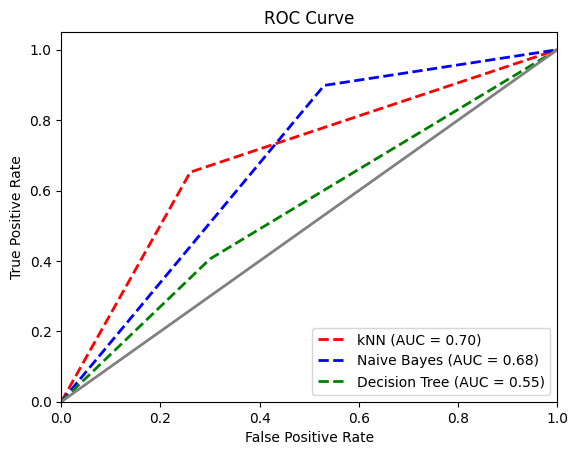

In [291]:
# Вычисление ROC-кривых
fpr_knn, tpr_knn, _ = roc_curve(y_test, res_knn_2)
fpr_nb, tpr_nb, _ = roc_curve(y_test, res_nb_2)
fpr_dt, tpr_dt, _ = roc_curve(y_test, res_dt_2)

# Рассчитать площадь под ROC-кривой (AUC-ROC)
auc_knn = roc_auc_score(y_test, res_knn_2)
auc_nb = roc_auc_score(y_test, res_nb_2)
auc_dt = roc_auc_score(y_test, res_dt_2)

# Визуализировать ROC-кривую
plt.plot(fpr_knn, tpr_knn, color='red', lw=2, linestyle='--', label=f'kNN (AUC = {auc_knn:.2f})')
plt.plot(fpr_nb, tpr_nb, color='blue', lw=2, linestyle='--', label=f'Naive Bayes (AUC = {auc_nb:.2f})')
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, linestyle='--', label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

<Axes: title={'center': 'Conf matrix DT'}>

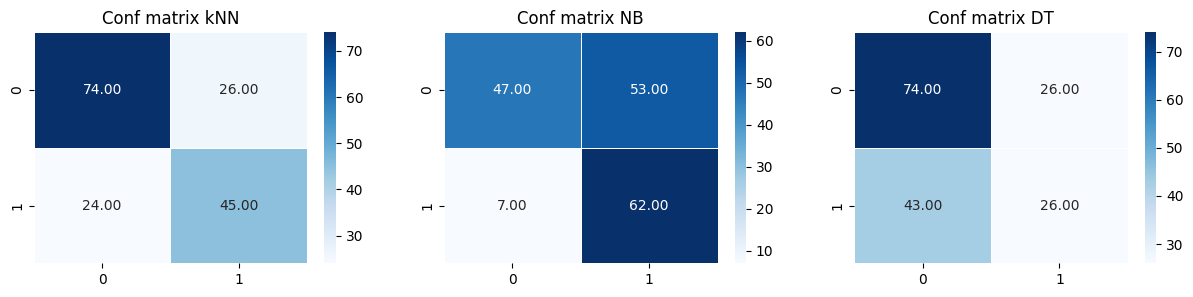

In [273]:
plt.figure(figsize=(15,3))

conf_matrix_knn = confusion_matrix(y_test, res_knn_2)
conf_matrix_nb = confusion_matrix(y_test, res_nb_2)
conf_matrix_dt = confusion_matrix(y_test, res_dt_2)

plt.subplot(1, 3, 1)
plt.title('Conf matrix kNN')
sns.heatmap(conf_matrix_knn,cmap='Blues',annot=True, fmt=".2f", linewidths=0.5)

plt.subplot(1, 3, 2)
plt.title('Conf matrix NB')
sns.heatmap(conf_matrix_nb,cmap='Blues',annot=True, fmt=".2f", linewidths=0.5)

plt.subplot(1, 3, 3)
plt.title('Conf matrix DT')
sns.heatmap(conf_matrix_dt,cmap='Blues',annot=True, fmt=".2f", linewidths=0.5)

In [274]:
print('Результат kNN: \n', classification_report(y_test, res_knn_2))
print('Результат NB: \n', classification_report(y_test, res_nb_2))
print('Результат Decision Tree: \n', classification_report(y_test, res_dt_2))

Результат kNN: 
               precision    recall  f1-score   support

           0       0.76      0.74      0.75       100
           1       0.63      0.65      0.64        69

    accuracy                           0.70       169
   macro avg       0.69      0.70      0.70       169
weighted avg       0.71      0.70      0.70       169

Результат NB: 
               precision    recall  f1-score   support

           0       0.87      0.47      0.61       100
           1       0.54      0.90      0.67        69

    accuracy                           0.64       169
   macro avg       0.70      0.68      0.64       169
weighted avg       0.74      0.64      0.64       169

Результат Decision Tree: 
               precision    recall  f1-score   support

           0       0.63      0.74      0.68       100
           1       0.50      0.38      0.43        69

    accuracy                           0.59       169
   macro avg       0.57      0.56      0.56       169
weighted avg  

Мы рассмотрели два новых подхода к построению модели классификации текста.  

Тем не менее, хочется отметить, что построение языковых моделей этим далеко не ограничивается.
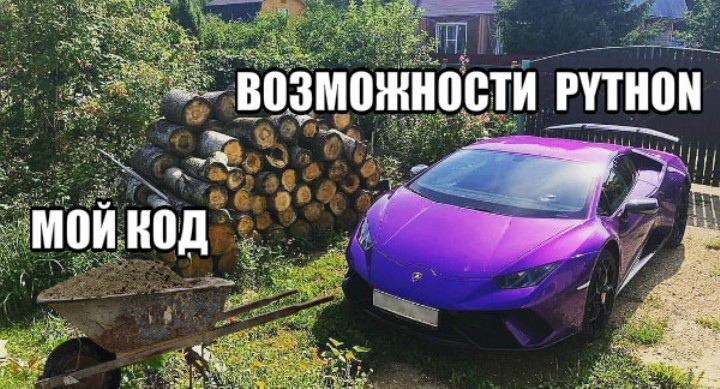

Если Вам интересна тема NLP, рекомендую посмотреть это [видео](https://www.youtube.com/watch?v=MBQdMQUZMQM&feature=youtu.be) 